## Dynamic flux based analysis


Dynamic Flux Balance Analysis (DFBA) is a dynamic simulation framework for biochemical processes. DFBA can be performed using different approaches such as static optimization (SOA), dynamic optimization (DOA), and direct approaches (DA). Few existing simulators address the theoretical and practical challenges of nonunique exchange fluxes or infeasible linear programs (LPs). Both are common sources of failure and inefficiencies for these simulators (Gomez et al., 2014). 

### Import the required libraries and the model.

In [158]:
### Import the required libraries and the model.
from pytest import approx
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas as pd
import numpy as np
import cobra
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline


model = read_sbml_model('2018_ATCC1015_GSM_iJB1325.xml') #The model is refered from (Brandl, J., Aguilar-Pontes, M. V., Schape, P., Norregaard, A., Arvas, M., Ram, A. F. J., Meyer, V., Tsang, A., de Vries, R. P., & Andersen, M. R. (2018). A community-driven reconstruction of the Aspergillus niger metabolic network. Fungal Biology and Biotechnology, 5, 16. )

'' is not a valid SBML 'SId'.


### Media setup

In [159]:
#Add extracellular metanolites
PNTOe = Metabolite('PNTOe', formula='C9H17NO5', name='(R)-Pantothenate', compartment='e') 
model.add_metabolites([PNTOe])

DHFe = Metabolite('DHFe', formula='C19H21N7O6', name='7,8-Dihydrofolate', compartment='e') 
model.add_metabolites([DHFe])

PABAe = Metabolite('PABAe', formula='C7H7NO2', name='4-Aminobenzoate', compartment='e') 
model.add_metabolites([PABAe])

PLe = Metabolite('PLe', formula='C8H9NO3', name='Pyridoxal', compartment='e') 
model.add_metabolites([PLe])

RIBOFLAVe = Metabolite('RIBOFLAVe', formula='C17H20N4O6', name='Riboflavin', compartment='e') 
model.add_metabolites([RIBOFLAVe])

#Add transport reactions
r2392 = Reaction('r2392')
r2392.name = '(R)-Pantothenate transport'
r2392.subsystem = "Transport"
r2392.lower_bound = -1000
r2392.add_metabolites({PNTOe: -1.0, model.metabolites.PNTO: 1.0})

r2393 = Reaction('r2393')
r2393.name = '7,8-Dihydrofolate transport'
r2393.lower_bound = -1000
r2393.subsystem = 'Transport'
r2393.add_metabolites({DHFe: -1.0, model.metabolites.DHF: 1.0})

r2394 = Reaction('r2394')
r2394.name = '4-Aminobenzoate transport'
r2394.lower_bound = -1000
r2394.subsystem = 'Transport'
r2394.add_metabolites({PABAe: -1.0, model.metabolites.PABA: 1.0})

r2395 = Reaction('r2395')
r2395.name = 'Pyridoxal transport'
r2395.lower_bound = -1000
r2395.subsystem = 'Transport'
r2395.add_metabolites({PLe: -1.0, model.metabolites.PL: 1.0})

r2396 = Reaction('r2396')
r2396.name = 'Riboflavin transport'
r2396.lower_bound = -1000
r2396.subsystem = 'Transport'
r2396.add_metabolites({RIBOFLAVe: -1.0, model.metabolites.RIBOFLAV: 1.0})

r2397 = Reaction('r2397')
r2397.name = 'Copper transport'
r2397.lower_bound = -1000
r2397.subsystem = 'Transport'
r2397.add_metabolites({model.metabolites.CUe: -1.0, model.metabolites.CU: 1.0})

#Add boundary conditions
model.add_boundary(model.metabolites.PNTOe, type="exchange", reaction_id= "BOUNDARY_PNTOe")
model.add_boundary(model.metabolites.DHFe, type="exchange", reaction_id= "BOUNDARY_DHFe")
model.add_boundary(model.metabolites.PABAe, type="exchange", reaction_id= "BOUNDARY_PABAe")
model.add_boundary(model.metabolites.PLe, type="exchange", reaction_id= "BOUNDARY_PLe")
model.add_boundary(model.metabolites.RIBOFLAVe, type="exchange", reaction_id= "BOUNDARY_RIBOFLAVe")
model.add_boundary(model.metabolites.CUe, type="exchange", reaction_id= "BOUNDARY_CUe")

medium_blank = {key: 0 for key in model.medium}
YESmedium = medium_blank # Setup the object for YESmedium

#Set the concentration for the amino acids
YESmedium['BOUNDARY_GLCe'] = 20 
# YESmedium['BOUNDARY_ALAe'] = 10
# YESmedium['BOUNDARY_ARGe'] = 10
# YESmedium['BOUNDARY_ASPe'] = 10
# YESmedium['BOUNDARY_CYSe'] = 10
# YESmedium['BOUNDARY_GLUe'] = 10
# YESmedium['BOUNDARY_GLYe'] = 10
# YESmedium['BOUNDARY_HISe'] = 10
# YESmedium['BOUNDARY_ILEe'] = 10
# YESmedium['BOUNDARY_LEUe'] = 10
# YESmedium['BOUNDARY_LYSe'] = 10
# YESmedium['BOUNDARY_METe'] = 10
# YESmedium['BOUNDARY_PHEe'] = 10
# YESmedium['BOUNDARY_PROe'] = 10
# YESmedium['BOUNDARY_SERe'] = 10
# YESmedium['BOUNDARY_THRe'] = 10
# YESmedium['BOUNDARY_TRPe'] = 10
# YESmedium['BOUNDARY_TYRe'] = 10
# YESmedium['BOUNDARY_VALe'] = 10

#Set the concentration for the supplements
YESmedium['BOUNDARY_NH4e'] = 5 #Ammonium  
YESmedium['BOUNDARY_SLFe'] = 5.5 #Sulfate
YESmedium['BOUNDARY_BTe'] = 2/10**6 #Biotin 
YESmedium['BOUNDARY_PNTOe'] = 400/10**6 #Pantothenic Acid
YESmedium['BOUNDARY_DHFe'] = 2/10**6 #Folic acid
YESmedium['BOUNDARY_MYOIe'] = 4000/10**6 #myo-Inositol
YESmedium['BOUNDARY_NICAe'] = 800/10**6 #Nicotinate
YESmedium['BOUNDARY_PABAe'] = 400/10**6 #4-Aminobenzoate
YESmedium['BOUNDARY_PLe'] = 800/10**6 #Pyridoxal
YESmedium['BOUNDARY_RIBOFLAVe'] = 200/10**6 #Riboflavin
YESmedium['BOUNDARY_THIAe'] = 800/10**6 #Thiamine
YESmedium['BOUNDARY_CUe'] = 80/10**6 #Copper
YESmedium['BOUNDARY_Ke'] = 2 #Potassium
YESmedium['BOUNDARY_FE2e'] = 200/10**6 #Ferric 
YESmedium['BOUNDARY_MNe'] = 400/10**6 #Manganese
YESmedium['BOUNDARY_MOe'] = 200/10**6 #Molybdate
YESmedium['BOUNDARY_ZNe'] = 400/10**6 #Zinc
YESmedium['BOUNDARY_PIe'] = 0 #Phosphate
YESmedium['BOUNDARY_CAe'] = 0.4 #Calcium 

#Set the condition
YESmedium['BOUNDARY_H2Oe'] = 1000 #Water
YESmedium['BOUNDARY_O2e'] = 1000 #Oxygen 

# Setting YES as control medium
model.medium = YESmedium



### Impose boundary for DFBA simulation

In [160]:
model.reactions.BOUNDARY_GLCe.bonds = -5, 0
model.reactions.BOUNDARY_O2e.bounds = -10, 0 #O2 limited condition
model.reactions.DRAIN_Biomass.bounds = 0, 0.4 #Growth rate constraint
model.reactions.r1976.bounds = 0,5  
model.reactions.r862.bounds = 10,10
model.reactions.BOUNDARY_ACe.bounds = 0, 5

### Indentify the main reactions

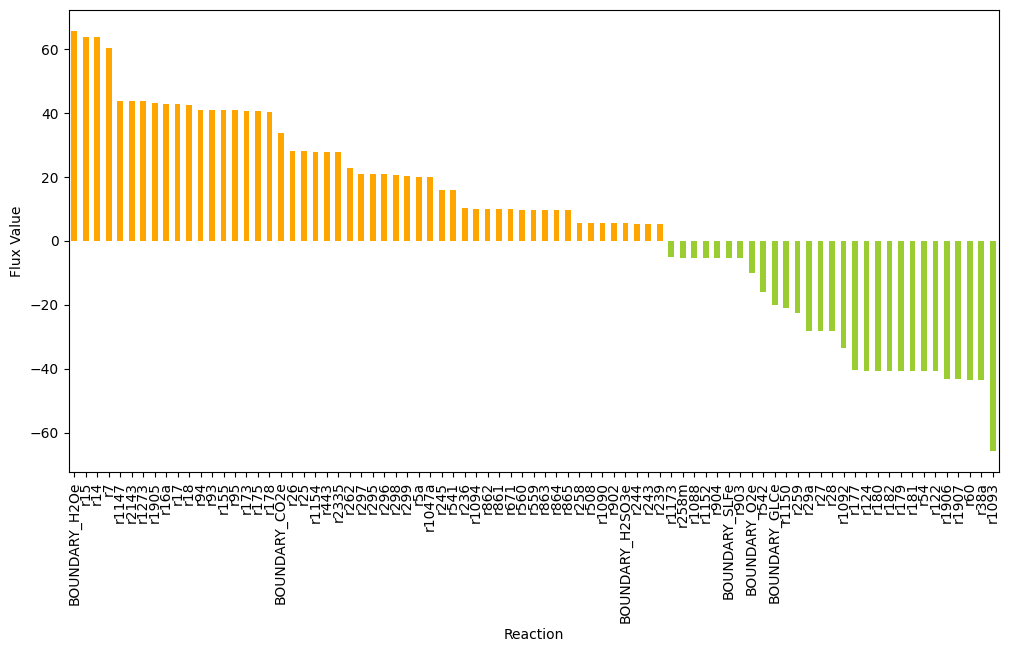

In [161]:
# finding solution
solution =  model.optimize()

df = pd.DataFrame(solution.fluxes)
# Remove rows where 'Column1' has a value of 0
df = df.loc[df['fluxes'] != 0]
df = df.loc[abs(df['fluxes']) > 5]
df = df.loc[abs(df['fluxes']) < 100]
df_sorted = df.sort_values(by='fluxes', ascending= False)
df_sorted 

# Assign colors based on the flux values
colors = ['orange' if value >= 0 else 'yellowgreen' for value in df_sorted['fluxes']]

# Plotting
plt.figure(figsize=(12, 6))
df_sorted['fluxes'].plot(kind='bar',  color=colors)
plt.xlabel('Reaction')
plt.ylabel('Flux Value')

plt.show()

### Define functions for DFBA simulation

In [164]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, yanD  = y  # expand the boundary species
    glucose_max_import = -30 * glucose / (0.5 + glucose)    
    model.reactions.BOUNDARY_GLCe.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose, yanD  = y # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['DRAIN_Biomass', 'BOUNDARY_GLCe' ,'r1976'], 
            ['max', 'max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

### Run the dynamic FBA simulation - Batch phase (Limited oxygen)

In [168]:
ts = np.linspace(0, 10, 100)  # Desired integration resolution and interval
y0 = [0.1, 140,  0]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

0it [00:00, ?it/s]

t = 10.000: : 85it [06:38,  4.69s/it]


### Plot timelines of biomass and glucose - Batch phase (Limited oxygen)

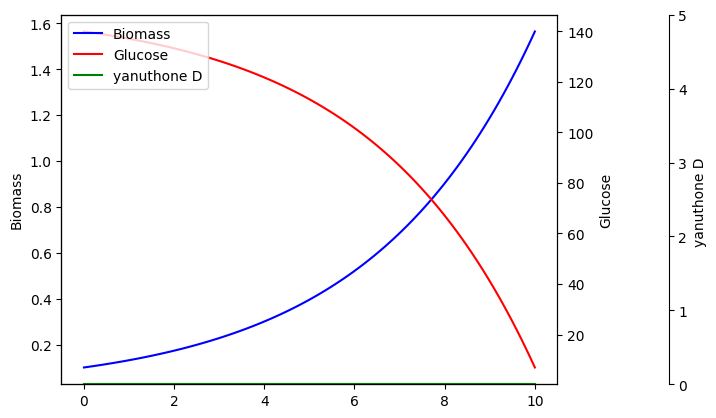

In [169]:
fig, ax1 = plt.subplots()

# Plot for Biomass
ax1.plot(sol.t, sol.y.T[:, 0], label='Biomass', color='b')

# Create a second y-axis for Succinate
ax2 = ax1.twinx()
ax2.plot(sol.t, sol.y.T[:, 1], label='Glucose', color='r')
ax2.set_ylabel('Glucose', color='Black')


#Create a third y-axis for Yanuthone D
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))  # Adjust the position of the third axis
ax3.plot(sol.t, sol.y.T[:, 2], label='yanuthone D', color='g')
ax3.set_ylabel('yanuthone D ', color='Black')


# Set y-axis limits for the third axis (Succinate)
ax3.set_ylim(0, 5)
ax1.set_ylabel('Biomass', color='Black')

# Adjust the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.show()


### Reimpose boundary for DFBA simulation

In [189]:
model.reactions.BOUNDARY_GLCe.bonds = -5, 0
model.reactions.BOUNDARY_O2e.bounds = -40, 0 #O2 Optimal condition
model.reactions.DRAIN_Biomass.bounds = 0, 0.38 #Growth rate constraint
model.reactions.r1976.bounds = 0,5  
model.reactions.r862.bounds = 10,10
model.reactions.BOUNDARY_ACe.bounds = 0, 5

In [190]:
ts = np.linspace(0, 10, 100)  # Desired integration resolution and interval
y0 = [0.1, 140,  0]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol2 = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 10.000: : 105it [07:45,  4.43s/it]


### Plot timelines of biomass and glucose - Batch phase

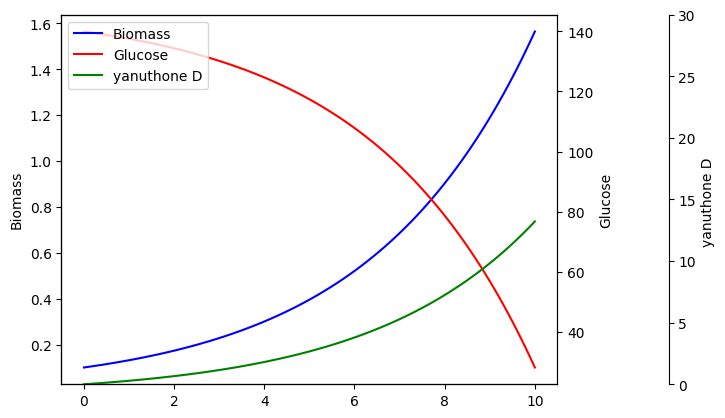

In [191]:
fig, ax1 = plt.subplots()

# Plot for Biomass
ax1.plot(sol2.t, sol2.y.T[:, 0], label='Biomass', color='b')

# Create a second y-axis for Succinate
ax2 = ax1.twinx()
ax2.plot(sol2.t, sol2.y.T[:, 1], label='Glucose', color='r')
ax2.set_ylabel('Glucose', color='Black')


#Create a third y-axis for Yanuthone D
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))  # Adjust the position of the third axis
ax3.plot(sol2.t, sol2.y.T[:, 2], label='yanuthone D', color='g')
ax3.set_ylabel('yanuthone D ', color='Black')


# Set y-axis limits for the third axis (Succinate)
ax3.set_ylim(0, 30)
ax1.set_ylabel('Biomass', color='Black')

# Adjust the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.show()


In [194]:
from matplotlib.lines import Line2D

### Visualization

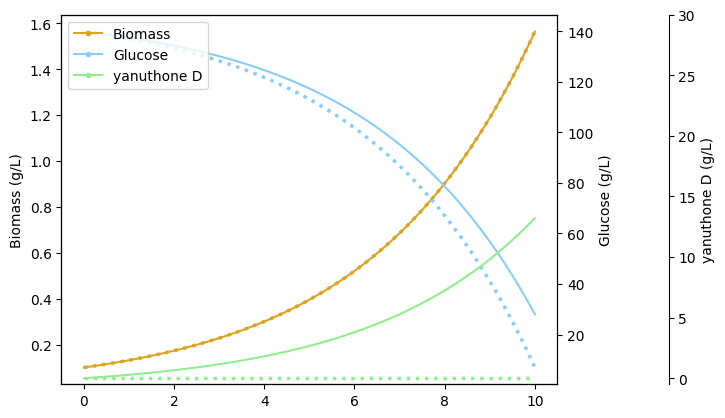

In [202]:
import matplotlib.pyplot as plt

#WT
# Plot for Biomass (Dotted Lines)
fig, ax1 = plt.subplots()
ax1.plot(sol.t, sol.y.T[:, 0], label='Biomass', color='goldenrod', linestyle='dotted', linewidth=2.5)
ax1.set_ylabel('Biomass (g/L)', color='Black')
# Create a second y-axis for Glucose
ax2 = ax1.twinx()
ax2.plot(sol.t, sol.y.T[:, 1], label='Glucose', color='lightskyblue', linestyle='dotted', linewidth=2.5)
ax2.set_ylabel('Glucose (g/L)', color='Black')

# Create a third y-axis for Yanuthone D
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))  # Adjust the position of the third axis
ax3.plot(sol.t, sol.y.T[:, 2], label='yanuthone D', color='lightgreen', linestyle='dotted', linewidth=2.5)
ax3.set_ylabel('yanuthone D (g/L)', color='Black')

# # Adjust the legend
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# lines3, labels3 = ax3.get_legend_handles_labels()
# ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

# Set y-axis limits for the third axis (yanuthone D)
ax3.set_ylim(-0.5, 30)


#MT
# Plot for Biomass (Solid Lines)
ax1.plot(sol2.t, sol2.y.T[:, 0], label='Biomass', color='goldenrod', linestyle='solid')

# Create a second y-axis for Glucose
ax2.plot(sol2.t, sol2.y.T[:, 1], label='Glucose', color='lightskyblue', linestyle='solid')


# Create a third y-axis for Yanuthone D
ax3.plot(sol2.t, sol2.y.T[:, 2], label='yanuthone D', color='lightgreen', linestyle='solid')

# Create legend handles with dots instead of lines
legend_handles = [
    Line2D([0], [0], color='goldenrod', marker='o', markersize=3),
    Line2D([0], [0], color='lightskyblue', marker='o', markersize=3),
    Line2D([0], [0], color='lightgreen', marker='o',  markersize=3),
]

# Add legend with custom handles
ax3.legend(handles=legend_handles, labels=['Biomass', 'Glucose', 'yanuthone D'], loc='upper left')

plt.show()
